## Target:

1. Increasing Test Accuracy >= 99.4 % and making it consistent.
2. Add Image Augmentation in Training dataset
3. Add Step LR

## Results:
1. Parameters: 7,878
2. Best Training Accuracy: 99.10
3. Best Test Accuracy: 99.51

##Analysis:

1. No overfitting
2. Test accuracy is stabilised and consistent over last few epochs.

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #transforms.RandomAffine(degrees=5, translate=(0.1,0.1),shear=(-1,1,-7,7)),
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                      #transforms.RandomAutocontrast(p=0.05),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
train = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


torch.Size([128, 1, 28, 28])
torch.Size([128])


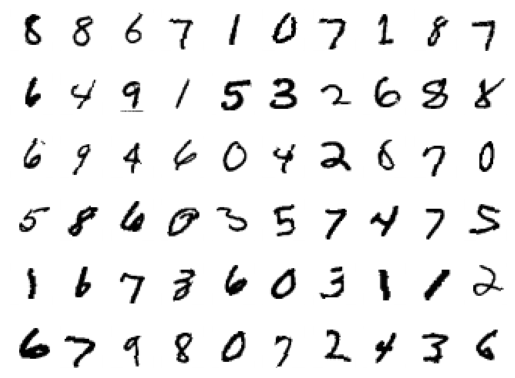

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 50, 3, stride=1, padding=1, bias=False),  #28>>28 | 1>>3 | 1>>1
            nn.ReLU(),
            nn.BatchNorm2d(50),
            nn.Dropout(0.05),
            nn.Conv2d(50, 10, 1, stride =1,padding=0, bias=False),  #28>>28 | 3>>3 | 1>>1
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05),
            nn.Conv2d(10, 10, 3, stride=1, padding=1, bias=False),#28>>28 | 3>>5 | 1>>1
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(0.05)

        )
        # Transition Block 1
        self.trans1 = nn.Sequential(
            nn.MaxPool2d(2, 2),#28>>14 | 5>>6 | 1>>2

        )
        # Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 16, 3, stride=1, padding=0, bias=False),#14>>12 | 6>>10 | 2>>2
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
        )
        # Transition Block 2
        self.trans2 = nn.Sequential(
            nn.Conv2d(16, 8, 1, stride=1, bias=False),#12>>12 | 10>>10 | 2>>2
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05),

        )

        # Block 4
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 8, 3, stride=1, padding=0, bias=False), #12>>10 | 10>>14 | 2>>2
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.05),
            nn.Conv2d(8, 16, 3, stride=1, padding=0, bias=False), #10>>8 | 14>>18 | 2>>2
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),
            nn.Conv2d(16, 16, 3, stride=1, padding=0, bias=False), #8>>6 | 18>>22 | 2>>2
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.05),

        )

        self.fc = nn.Sequential(
            nn.Conv2d(16, 10, 1, stride=1, padding=0, bias=False), #6>>6 | 22>>26 | 2>>2
            #nn.ReLU(),
            #nn.BatchNorm2d(1),
            #nn.Dropout(0.05),
            #nn.Linear(10, 10)

        )
        self.gap = nn.Sequential(
            #nn.AvgPool2d(kernel_size=16)
            nn.AdaptiveAvgPool2d((1, 1))
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        #x = self.norm4(x)
        #print('SIze', x.size)
        #x = x.view(-1, 3200)

        #x = x.view(x.size(0), -1)

        x = self.gap(x)
        x = self.fc(x)
        #x = self.gpool(x)
        x = x.view(-1, 10)
        #x = F.relu(self.fc1(x))
        #x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 50, 28, 28]             450
              ReLU-2           [-1, 50, 28, 28]               0
       BatchNorm2d-3           [-1, 50, 28, 28]             100
           Dropout-4           [-1, 50, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             500
              ReLU-6           [-1, 10, 28, 28]               0
       BatchNorm2d-7           [-1, 10, 28, 28]              20
           Dropout-8           [-1, 10, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             900
             ReLU-10           [-1, 10, 28, 28]               0
      BatchNorm2d-11           [-1, 10, 28, 28]              20
          Dropout-12           [-1, 10, 28, 28]               0
        MaxPool2d-13           [-1, 10, 14, 14]               0
           Conv2d-14           [-1, 16,

In [ ]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []
def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)
    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
num_epochs = 15
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

Epoch 1


Loss=0.21834535896778107 Batch_id=468 Accuracy=87.15: 100%|██████████| 469/469 [00:27<00:00, 17.29it/s]



Test set: Average loss: 0.0767, Accuracy: 9792/10000 (97.92%)

Epoch 2


Loss=0.12659494578838348 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s]



Test set: Average loss: 0.0520, Accuracy: 9856/10000 (98.56%)

Epoch 3


Loss=0.06479353457689285 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:28<00:00, 16.32it/s]



Test set: Average loss: 0.0343, Accuracy: 9896/10000 (98.96%)

Epoch 4


Loss=0.07769457995891571 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:28<00:00, 16.18it/s]



Test set: Average loss: 0.0365, Accuracy: 9891/10000 (98.91%)

Epoch 5


Loss=0.012733095325529575 Batch_id=468 Accuracy=98.39: 100%|██████████| 469/469 [00:29<00:00, 16.05it/s]



Test set: Average loss: 0.0304, Accuracy: 9901/10000 (99.01%)

Epoch 6


Loss=0.035069290548563004 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:27<00:00, 17.09it/s]



Test set: Average loss: 0.0254, Accuracy: 9926/10000 (99.26%)

Epoch 7


Loss=0.045441050082445145 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]



Test set: Average loss: 0.0267, Accuracy: 9911/10000 (99.11%)

Epoch 8


Loss=0.01563820242881775 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:27<00:00, 17.05it/s]



Test set: Average loss: 0.0257, Accuracy: 9925/10000 (99.25%)

Epoch 9


Loss=0.03262026980519295 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:27<00:00, 16.99it/s]



Test set: Average loss: 0.0295, Accuracy: 9908/10000 (99.08%)

Epoch 10


Loss=0.08824995160102844 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:27<00:00, 16.86it/s]



Test set: Average loss: 0.0245, Accuracy: 9928/10000 (99.28%)

Epoch 11


Loss=0.018939033150672913 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]



Test set: Average loss: 0.0179, Accuracy: 9947/10000 (99.47%)

Epoch 12


Loss=0.03553799167275429 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:27<00:00, 16.75it/s]



Test set: Average loss: 0.0169, Accuracy: 9951/10000 (99.51%)

Epoch 13


Loss=0.03822131082415581 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:28<00:00, 16.33it/s]



Test set: Average loss: 0.0173, Accuracy: 9952/10000 (99.52%)

Epoch 14


Loss=0.019983971491456032 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:28<00:00, 16.63it/s]



Test set: Average loss: 0.0173, Accuracy: 9948/10000 (99.48%)

Epoch 15


Loss=0.004643117543309927 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:28<00:00, 16.39it/s]



Test set: Average loss: 0.0168, Accuracy: 9951/10000 (99.51%)



Text(0.5, 1.0, 'Test Accuracy')

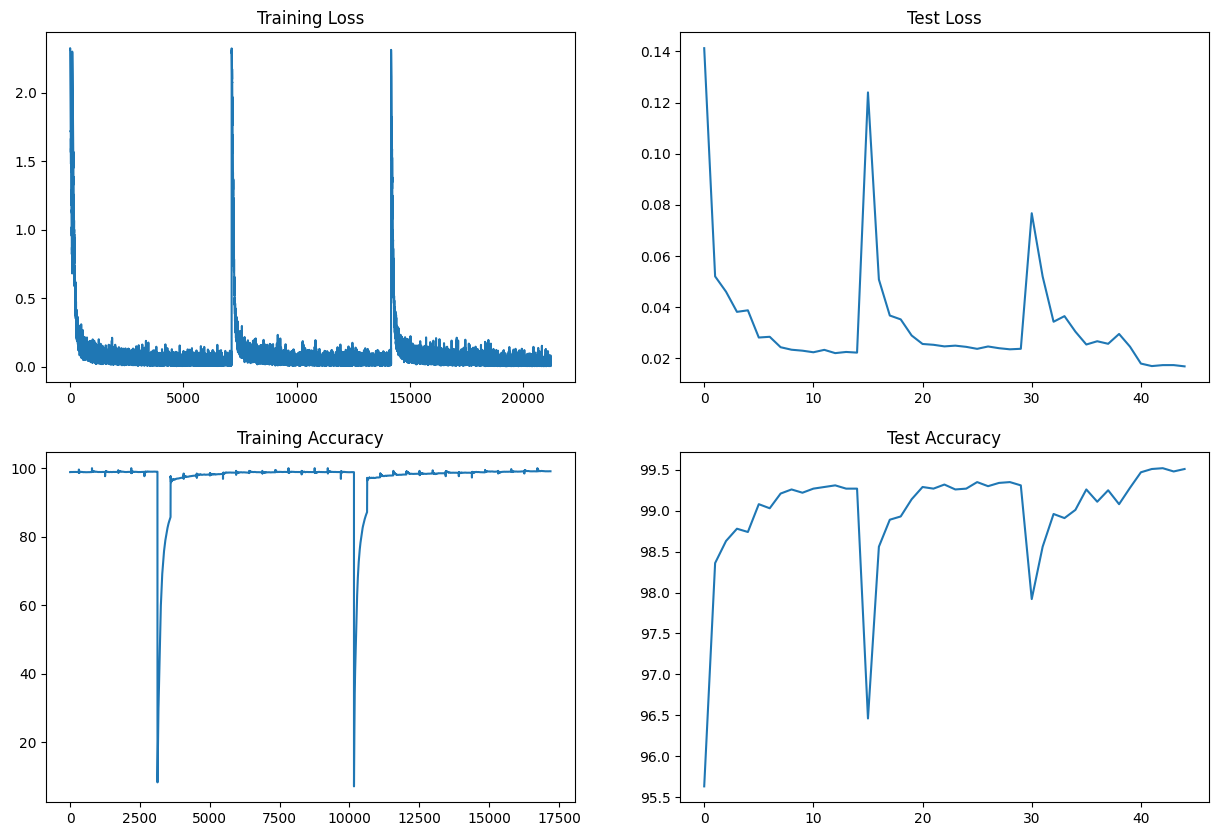

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")